# NP Problems

## Setup

<img src="https://homes.luddy.indiana.edu/achauhan/Teaching/B403/LectureNotes/images/12-roadmap.jpg" alt="My Photo" width="500"/>

In [ ]:
pip install z3-solver

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.5/29.5 MB 63.8 MB/s eta 0:00:00


## 3 SAT Problem

### Problem Generator

In [ ]:
import random

def generate_3sat_instance(num_vars, num_clauses, use_random_weights=True):
    true_probability = random.random()
    false_probability = 1 - true_probability
    if (use_random_weights):
        solution = {i: random.choices([True, False], weights=[true_probability, false_probability])[0] for i in range(1, num_vars + 1)}
    else:
        solution = {i: random.choice([True, False]) for i in range(1, num_vars + 1)}

    clauses = []
    variables = list(range(1, num_vars + 1))

    for _ in range(num_clauses):
        clause_vars = random.sample(variables, 3)
        clause = [v * random.choice([-1, 1]) for v in clause_vars]

        is_satisfied = False
        for literal in clause:
            var_index = abs(literal)
            var_value = solution[var_index]
            if (literal > 0 and var_value is True) or (literal < 0 and var_value is False):
                is_satisfied = True
                break

        if is_satisfied:
            clauses.append(clause)
        else:
            literal_to_flip = random.choice([0, 1, 2])
            clause[literal_to_flip] *= -1
            clauses.append(clause)

    return clauses, solution


instance_clauses, solution = generate_3sat_instance(num_vars=3, num_clauses=3)

print("=" * 75)
print(f"Variables: {len(solution)}, Clauses: {len(instance_clauses)}")
sat_problem = []
for clause in instance_clauses:
    temp_clause = [f"{'~' if var < 0 else ''}x{abs(var)}" for var in clause]
    str_clause ="(" + " v ".join(temp_clause) + ")"
    sat_problem.append(str_clause)
sat_problem_str = " ∧ ".join(sat_problem)
print(f"Generated Clauses: {sat_problem_str}")
print("=" * 75)

print("Satisfying Assignment:")
for var, val in solution.items():
    print(f"  x{var} = {val}")
print("=" * 75)

Variables: 3, Clauses: 3
Generated Clauses: (~x2 v x1 v ~x3) ∧ (~x3 v ~x1 v ~x2) ∧ (x1 v x2 v x3)
Satisfying Assignment:
  x1 = False
  x2 = False
  x3 = True


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def visualize_3sat_instance(clauses: list[list[int]], solution: dict[int, bool]):
    G = nx.Graph()
    num_vars = len(solution)
    variables = list(range(1, num_vars + 1))

    var_nodes = [f"x{i}" for i in variables]
    clause_nodes = [f"c{i}" for i in range(len(clauses))]

    G.add_nodes_from(var_nodes, bipartite=0)
    G.add_nodes_from(clause_nodes, bipartite=1)

    for i, clause in enumerate(clauses):
        for literal in clause:
            var_index = abs(literal)
            edge_color = "limegreen" if literal > 0 else "tomato"
            G.add_edge(f"x{var_index}", f"c{i}", style="solid", color=edge_color)

    plt.figure(figsize=(8, 6))
    pos = dict()
    pos.update((node, (1, i)) for i, node in enumerate(var_nodes))
    pos.update((node, (2, i * (len(var_nodes) / len(clause_nodes)))) for i, node in enumerate(clause_nodes))
    var_colors = ["limegreen" if solution[i] else "tomato" for i in variables]
    nx.draw_networkx_nodes(G, pos, nodelist=var_nodes, node_color=var_colors, node_shape="o", node_size=1000)
    nx.draw_networkx_nodes(G, pos, nodelist=clause_nodes, node_color="skyblue", node_shape="s", node_size=1000)

    limegreen_edges = [(u, v) for u, v, d in G.edges(data=True) if d["color"] == "limegreen"]
    tomato_edges = [(u, v) for u, v, d in G.edges(data=True) if d["color"] == "tomato"]
    nx.draw_networkx_edges(G, pos, edgelist=limegreen_edges, edge_color="limegreen", style="solid", width=1.5)
    nx.draw_networkx_edges(G, pos, edgelist=tomato_edges, edge_color="tomato", style="solid", width=1.5)

    nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")
    plt.title("3-SAT Problem", size=16)

    true_patch = mpatches.Patch(color="limegreen", label="Variable = TRUE")
    false_patch = mpatches.Patch(color="tomato", label="Variable = FALSE")
    clause_patch = mpatches.Patch(color="skyblue", label="Clause Node")
    pos_lit_line = plt.Line2D([0], [0], color="limegreen", lw=1.5, linestyle="-", label="Positive Literal (x)")
    neg_lit_line = plt.Line2D([0], [0], color="tomato", lw=1.5, linestyle="-", label="Negative Literal (~x)")
    plt.legend(handles=[true_patch, false_patch, clause_patch, pos_lit_line, neg_lit_line], loc="best")
    plt.tight_layout()
    plt.show()

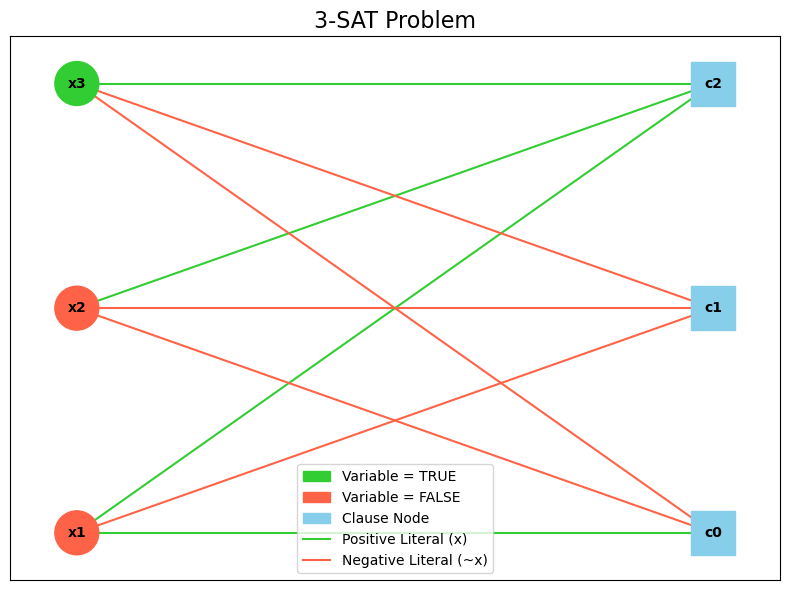

In [ ]:
visualize_3sat_instance(instance_clauses, solution)

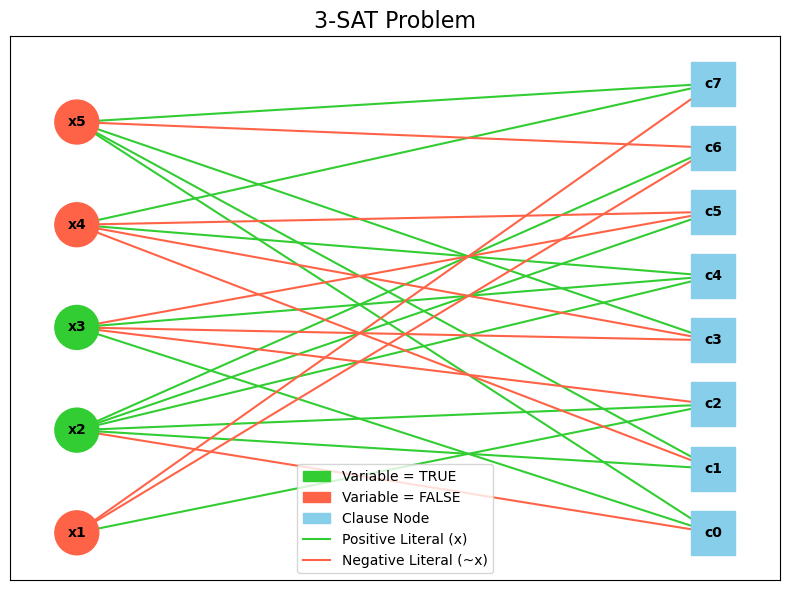

In [ ]:
instance_clauses2, solution2 = generate_3sat_instance(num_vars=5, num_clauses=8, use_random_weights=False)
visualize_3sat_instance(instance_clauses2, solution2)

### Solving Problem Using Z3

In [ ]:
from z3 import *
import time

def solve_3sat_with_z3(clauses, num_vars):
    start_time = time.time()
    solver = Solver()
    bool_vars = {i: Bool(f"x{i}") for i in range(1, num_vars + 1)}

    for clause in clauses:
        z3_clause = []
        for literal in clause:
            var_index = abs(literal)
            z3_var = bool_vars[var_index]

            if literal > 0:
                z3_clause.append(z3_var)
            else:
                z3_clause.append(Not(z3_var))

        solver.add(Or(z3_clause))

    check_result = solver.check()
    end_time = time.time()
    execution_time = end_time - start_time

    if check_result == sat:
        model = solver.model()
        solution = {i: bool(model.eval(bool_vars[i])) for i in range(1, num_vars + 1)}
        return solution, execution_time
    else:
        return None, execution_time


NUM_VARS = 4
NUM_CLAUSES = 6
instance_clauses, solution = generate_3sat_instance(num_vars=NUM_VARS, num_clauses=NUM_CLAUSES, use_random_weights=False)
z3_solution, solve_time = solve_3sat_with_z3(instance_clauses, NUM_VARS)

print("=" * 75)
print(f"Variables: {len(solution)}, Clauses: {len(instance_clauses)}")
sat_problem = []
for clause in instance_clauses:
    temp_clause = [f"{'~' if var < 0 else ''}x{abs(var)}" for var in clause]
    str_clause ="(" + " v ".join(temp_clause) + ")"
    sat_problem.append(str_clause)
sat_problem_str = " ∧ ".join(sat_problem)
print(f"Generated Clauses: {sat_problem_str}")
print("=" * 75)

print("Planted Satisfying Assignment:")
for var, val in sorted(solution.items()):
    print(f"   x{var} = {val}")
print("=" * 75)


if z3_solution is not None:
    print("Z3 Found a Satisfying Assignment:")
    for var, val in sorted(z3_solution.items()):
        print(f"   x{var} = {val}")
else:
    print("Z3 proved the instance is UNSATISFIABLE.")
print(f"Z3 Solver execution time: {solve_time:.6f} seconds")

print("=" * 75)

Variables: 4, Clauses: 6
Generated Clauses: (~x2 v ~x3 v ~x1) ∧ (x4 v x3 v x2) ∧ (x3 v ~x4 v x2) ∧ (~x3 v ~x1 v ~x2) ∧ (~x4 v x3 v ~x2) ∧ (~x3 v x4 v x1)
Planted Satisfying Assignment:
   x1 = True
   x2 = True
   x3 = False
   x4 = False
Z3 Found a Satisfying Assignment:
   x1 = True
   x2 = False
   x3 = True
   x4 = False
Z3 Solver execution time: 0.000000 seconds


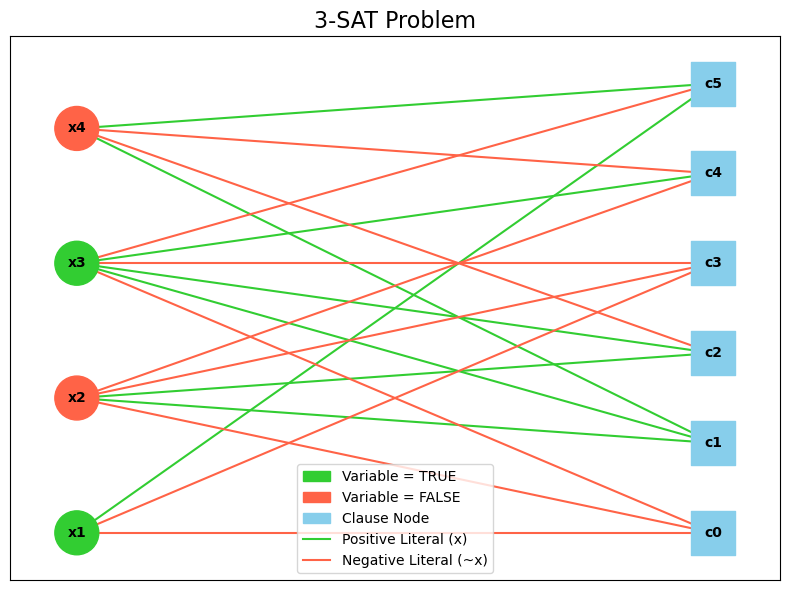

In [ ]:
visualize_3sat_instance(instance_clauses, z3_solution)

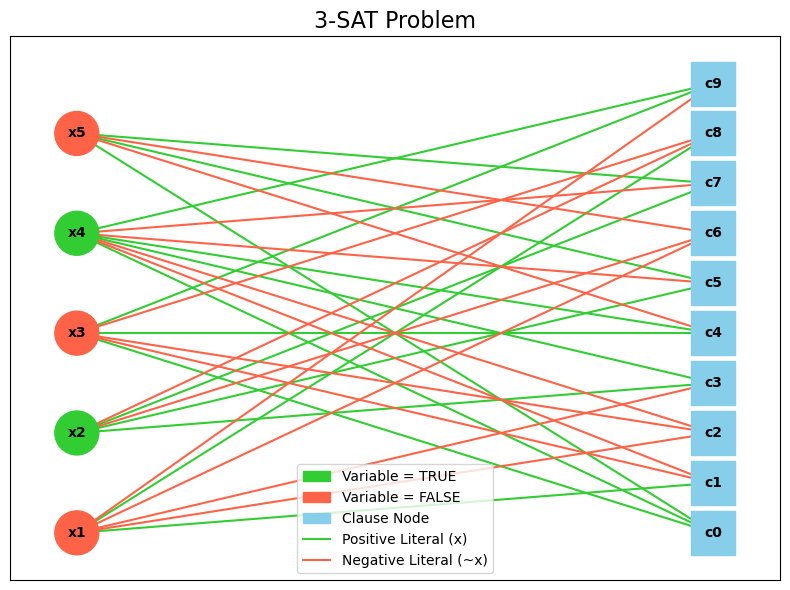

In [ ]:
instance_clauses2, solution2 = generate_3sat_instance(num_vars=5, num_clauses=10, use_random_weights=False)
z3_solution2, _ = solve_3sat_with_z3(clauses=instance_clauses2, num_vars=5)
visualize_3sat_instance(instance_clauses2, z3_solution2)

### Answer Verifier

In [ ]:
def verify_3sat_solution(assignment, clauses):
    for clause in clauses:
        is_clause_satisfied = False
        for literal in clause:
            var_index = abs(literal)

            if var_index not in assignment:
                return False, f"Verification FAILED: Variable {var_index} not found in the assignment."

            var_value = bool(assignment[var_index])
            if (literal > 0 and var_value is True) or (literal < 0 and var_value is False):
                is_clause_satisfied = True
                break

        if not is_clause_satisfied:
            return False, f"Verification FAILED: Clause {clause} is not satisfied by the assignment."

    return True, "Verification PASSED: The assignment satisfies all clauses."

In [ ]:
instance_clauses, solution = generate_3sat_instance(10, 40)
z3_solution, solve_time = solve_3sat_with_z3(instance_clauses, len(solution))

print("=" * 75)
print(f"Variables: {len(solution)}, Clauses: {len(instance_clauses)}")
print(f"Planted Satisfying Assignment: {solution}")
print("=" * 75)

if z3_solution is not None:
    print(f"Z3 Found a Satisfying Assignment: {z3_solution}")
    is_correct, message = verify_3sat_solution(z3_solution, instance_clauses)
    print(message)
else:
    print("Z3 proved the instance is UNSATISFIABLE.")
print(f"Z3 Solver execution time: {solve_time:.6f} seconds")
print("=" * 75)

Variables: 10, Clauses: 40
Planted Satisfying Assignment: {1: False, 2: False, 3: False, 4: False, 5: False, 6: True, 7: True, 8: True, 9: True, 10: False}
Z3 Found a Satisfying Assignment: {1: False, 2: False, 3: False, 4: False, 5: False, 6: True, 7: True, 8: True, 9: True, 10: False}
Verification PASSED: The assignment satisfies all clauses.
Z3 Solver execution time: 0.007173 seconds


## Subset Sum Problem

### Problem Generator

In [ ]:
import random

def generate_subset_sum_instance(set_size, subset_size, min_val=10, max_val=100):
    solution_subset = [random.randint(min_val, max_val) for _ in range(subset_size)]
    target_sum = sum(solution_subset)

    other_count = set_size - subset_size
    others = [random.randint(min_val, max_val) for _ in range(other_count)]

    full_set = solution_subset + others
    random.shuffle(full_set)

    return target_sum, full_set, sorted(solution_subset)


target, number_set, solution = generate_subset_sum_instance(set_size=15, subset_size=4)

print("=" * 75)
print(f"Set Size: {len(number_set)}, Target Sum: {target}")
print(f"Full Set: {sorted(number_set)}")
print("=" * 75)
print(f"Subset Size: {len(solution)}, Subset Sum: {sum(solution)}")
print(f"Solution Subset: {solution}")
print("=" * 75)

Set Size: 15, Target Sum: 233
Full Set: [16, 20, 20, 24, 30, 42, 43, 53, 54, 65, 68, 77, 90, 95, 99]
Subset Size: 4, Subset Sum: 233
Solution Subset: [16, 54, 68, 95]


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def visualize_subset_sum(full_set, target_sum, solution_subset):
    colors = []
    solution_copy = list(solution_subset)

    for num in full_set:
        if num in solution_copy:
            colors.append("limegreen")
            solution_copy.remove(num)
        else:
            colors.append("lightgray")

    x_labels = [str(n) for n in full_set]
    x_pos = range(len(full_set))

    plt.figure(figsize=(8, 6))
    plt.bar(x_pos, full_set, color=colors, tick_label=x_labels)

    plt.ylabel("Value of Number")
    plt.xlabel("Numbers in the Set")
    plt.title(f"Subset Sum Problem (Target Sum = {target_sum})", size=16)

    solution_patch = mpatches.Patch(color="limegreen", label="Numbers in Solution Subset")
    other_patch = mpatches.Patch(color="lightgray", label="Other Numbers")
    plt.legend(handles=[solution_patch, other_patch], loc="best")

    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

def visualize_subset_sum_comparison(target_sum: int, solution_subset: list[int]):
    subset_sum = sum(solution_subset)
    cmap = plt.get_cmap("tab20")
    colors = [cmap(i % 20) for i in range(len(solution_subset))]

    fig, ax = plt.subplots(figsize=(7, 2))
    ax.barh(y=1, width=target_sum, color="limegreen", edgecolor="black", height=0.5, label="Target Sum", alpha=0.8)

    start = 0
    for i, val in enumerate(solution_subset):
        ax.barh(y=0, width=val, left=start, color=colors[i], edgecolor="black", height=0.5)
        start += val

    ax.text(target_sum + target_sum * 0.02, 1, f"= {target_sum}", va="center", ha="left", fontsize=10)
    ax.text(subset_sum + target_sum * 0.02, 0, f"= {subset_sum}", va="center", ha="left", fontsize=10)


    ax.set_yticks([0, 1])
    ax.set_yticklabels(["Subset Sum", "Target Sum"])
    ax.set_xlim(0, max(target_sum, subset_sum) * 1.15)
    ax.set_xlabel("Sum Value")
    ax.set_title("Subset Sum vs Target Sum", fontsize=16)

    ax.grid(axis="x", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

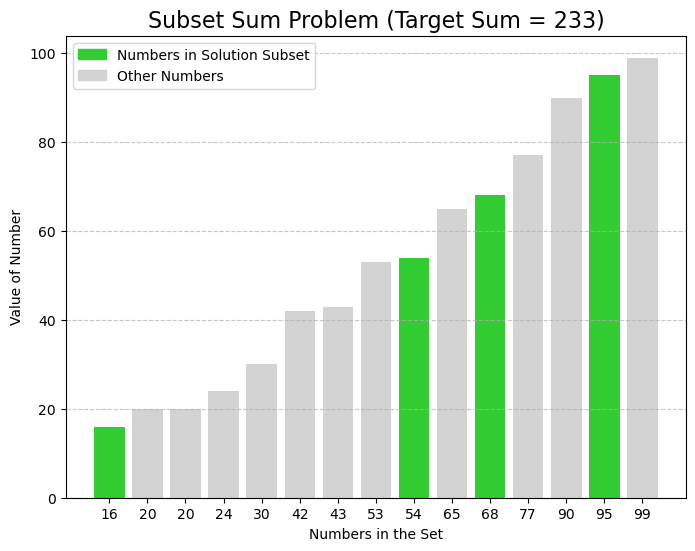

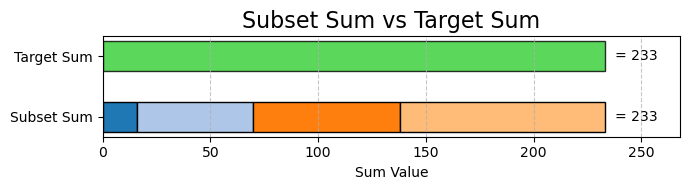

In [ ]:
visualize_subset_sum(sorted(number_set), target, solution)
visualize_subset_sum_comparison(target, solution)

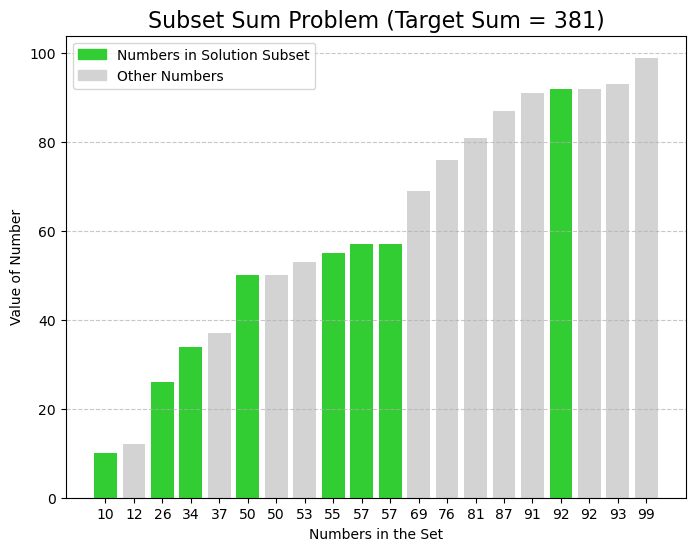

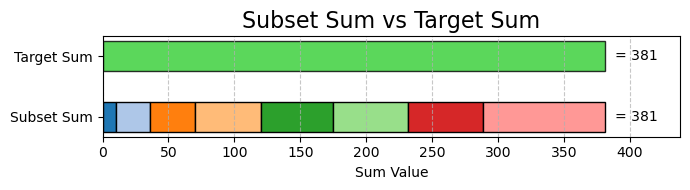

In [ ]:
target2, number_set2, solution2 = generate_subset_sum_instance(set_size=20, subset_size=8)
visualize_subset_sum(sorted(number_set2), target2, solution2)
visualize_subset_sum_comparison(target2, solution2)

### Solving Problem Using Z3

In [ ]:
from z3 import *
import time

def solve_subset_sum_with_z3(target_sum,number_set):
    start_time = time.time()
    solver = Solver()
    bool_vars = [Bool(f"b_{i}") for i in range(len(number_set))]
    sum_constraint = Sum([If(bool_vars[i], number_set[i], 0) for i in range(len(number_set))]) == target_sum
    solver.add(sum_constraint)

    check_result = solver.check()
    end_time = time.time()
    execution_time = end_time - start_time

    if check_result == sat:
        model = solver.model()
        solution_subset = [number_set[i] for i, var in enumerate(bool_vars) if is_true(model.eval(var))]
        return sorted(solution_subset), execution_time
    else:
        return None, execution_time


target, number_set, solution = generate_subset_sum_instance(set_size=15, subset_size=4, min_val=10, max_val=100)
z3_solution, solve_time = solve_subset_sum_with_z3(target, number_set)

print("=" * 75)
print(f"Set Size: {len(number_set)}, Target Sum: {target}")
print(f"Full Set: {sorted(number_set)}")
print("=" * 75)
print(f"Subset Size: {len(solution)}, Subset Sum: {sum(solution)}")
print(f"Planted Solution Subset: {solution}")
print("=" * 75)

if z3_solution is not None:
    print(f"Z3 Subset Size: {len(z3_solution)}, Z3 Subset Sum: {sum(z3_solution)}")
    print(f"Z3 Found a Solution Subset: {z3_solution}")
else:
    print("Z3 proved no such subset exists.")
print(f"Z3 Solver execution time: {solve_time:.6f} seconds")
print("=" * 75)

Set Size: 15, Target Sum: 314
Full Set: [11, 11, 12, 36, 43, 49, 54, 57, 66, 70, 86, 90, 93, 100, 100]
Subset Size: 4, Subset Sum: 314
Planted Solution Subset: [54, 70, 90, 100]
Z3 Subset Size: 5, Z3 Subset Sum: 314
Z3 Found a Solution Subset: [36, 43, 49, 86, 100]
Z3 Solver execution time: 0.000733 seconds


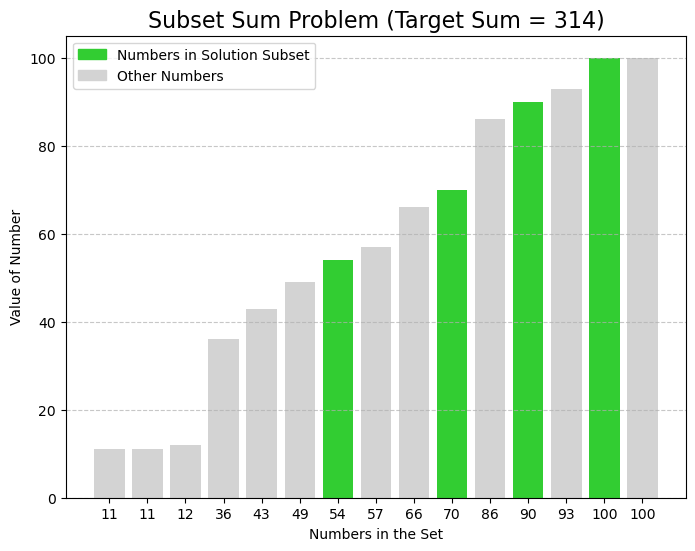

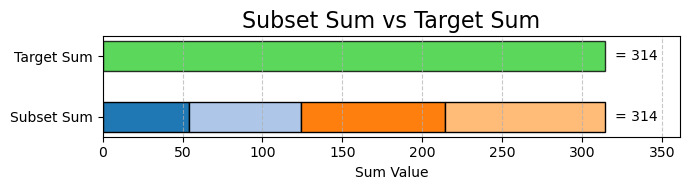

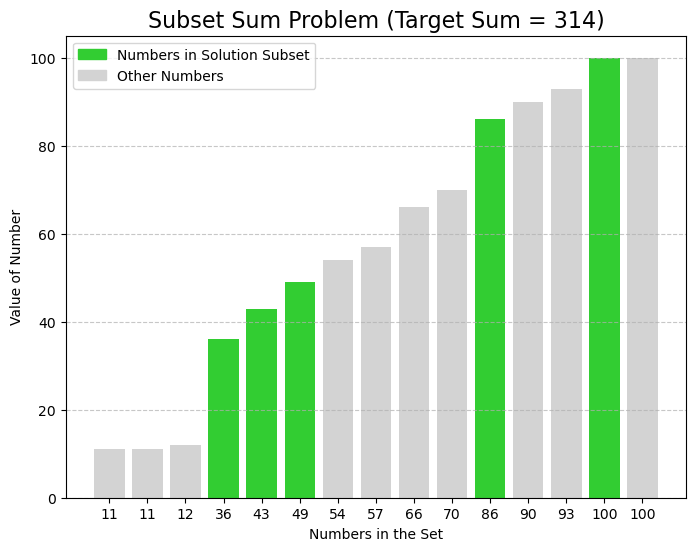

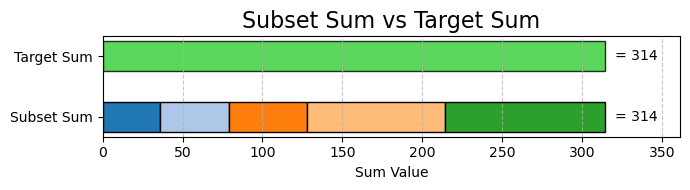

In [ ]:
visualize_subset_sum(sorted(number_set), target, solution)
visualize_subset_sum_comparison(target, solution)
visualize_subset_sum(sorted(number_set), target, z3_solution)
visualize_subset_sum_comparison(target, z3_solution)

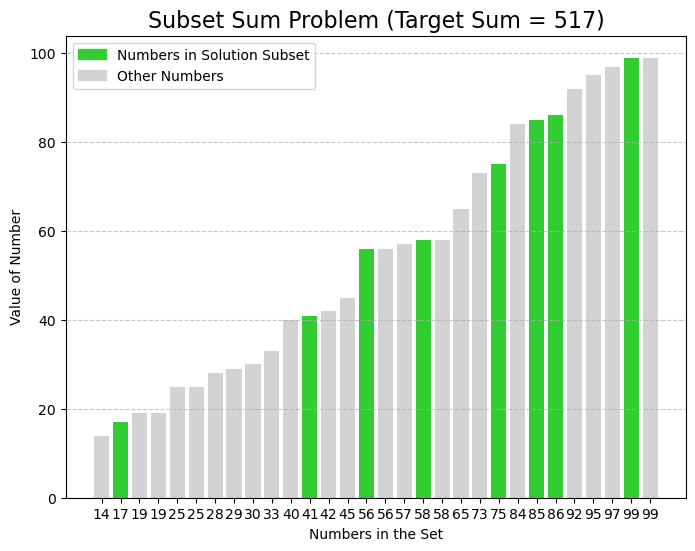

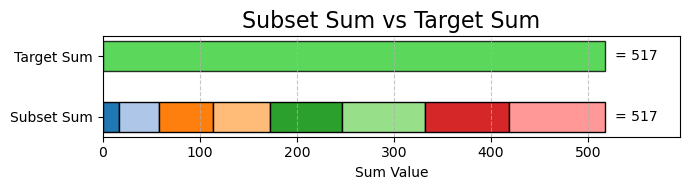

In [ ]:
target2, number_set2, solution2 = generate_subset_sum_instance(set_size=30, subset_size=10)
z3_solution2, _ = solve_subset_sum_with_z3(target2, number_set2)
visualize_subset_sum(sorted(number_set2), target2, z3_solution2)
visualize_subset_sum_comparison(target2, z3_solution2)

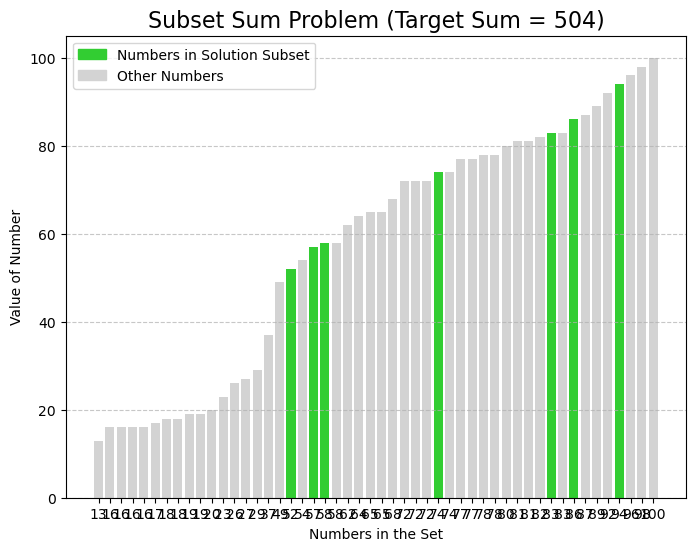

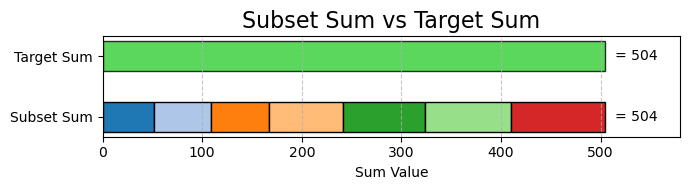

In [ ]:
target2, number_set2, solution2 = generate_subset_sum_instance(set_size=50, subset_size=10)
z3_solution2, _ = solve_subset_sum_with_z3(target2, number_set2)
visualize_subset_sum(sorted(number_set2), target2, z3_solution2)
visualize_subset_sum_comparison(target2, z3_solution2)

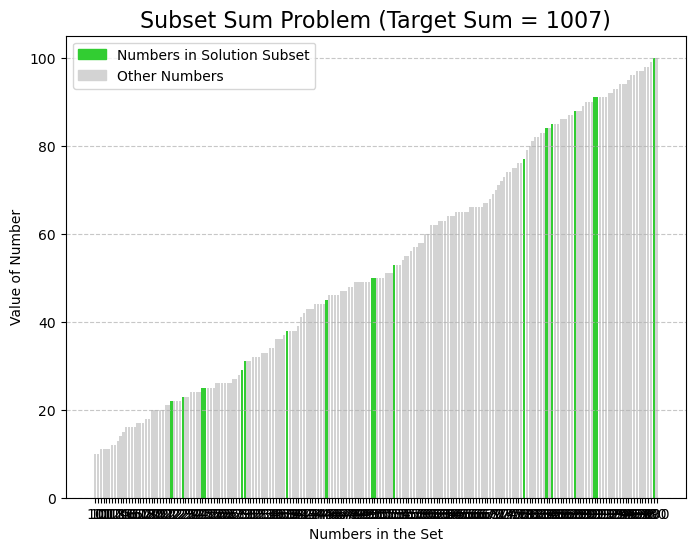

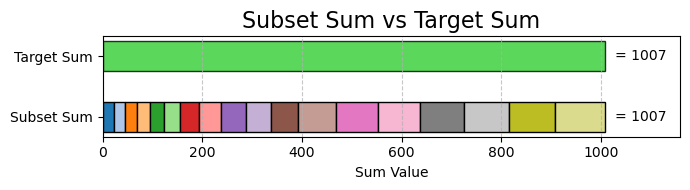

In [ ]:
target2, number_set2, solution2 = generate_subset_sum_instance(set_size=200, subset_size=20)
z3_solution2, _ = solve_subset_sum_with_z3(target2, number_set2)
visualize_subset_sum(sorted(number_set2), target2, z3_solution2)
visualize_subset_sum_comparison(target2, z3_solution2)

### Answer Verifier

In [ ]:
def verify_subset_sum_solution(solution_subset, target_sum):
    actual_sum = sum(solution_subset)
    if actual_sum == target_sum:
        return True, f"Verification PASSED: Subset sum {actual_sum} matches target {target_sum}."
    else:
        return False, f"Verification FAILED: Subset sum {actual_sum} does not match target {target_sum}."

In [ ]:
target, number_set, solution = generate_subset_sum_instance(set_size=50, subset_size=10)
z3_solution, solve_time = solve_subset_sum_with_z3(target, number_set)

print("=" * 75)
print(f"Set Size: {len(number_set)}, Target Sum: {target}")
print(f"Full Set: {sorted(number_set)}")
print("=" * 75)
print(f"Subset Size: {len(solution)}, Subset Sum: {sum(solution)}")
print(f"Solution Subset: {solution}")
print("=" * 75)

if z3_solution is not None:
    print(f"Z3 Subset Size: {len(z3_solution)}, Z3 Subset Sum: {sum(z3_solution)}")
    print(f"Z3 Found a Solution Subset: {z3_solution}")
    is_correct, message = verify_subset_sum_solution(z3_solution, target)
    print(message)
else:
    print("Z3 proved no such subset exists.")
print(f"Z3 Solver execution time: {solve_time:.6f} seconds")
print("=" * 75)

Set Size: 50, Target Sum: 435
Full Set: [11, 15, 16, 17, 22, 22, 23, 23, 25, 26, 28, 29, 30, 30, 31, 37, 37, 39, 40, 43, 44, 45, 46, 47, 47, 49, 49, 53, 55, 57, 57, 60, 61, 61, 63, 63, 68, 68, 69, 70, 73, 74, 80, 83, 86, 88, 90, 95, 97, 100]
Subset Size: 10, Subset Sum: 435
Solution Subset: [16, 22, 23, 25, 43, 47, 49, 60, 70, 80]
Z3 Subset Size: 9, Z3 Subset Sum: 435
Z3 Found a Solution Subset: [22, 23, 23, 30, 45, 49, 69, 74, 100]
Verification PASSED: Subset sum 435 matches target 435.
Z3 Solver execution time: 0.009431 seconds


## Minimum Vertex Cover Problem

### Problem Generator

In [ ]:
import random

def add_edge(graph, u, v):
    if u not in graph[v]:
        graph[u].append(v)
        graph[v].append(u)

def generate_vc_problem(num_vertices: int, vc_ratio = 0.4, edge_density = 0.5):
    all_vertices = list(range(num_vertices))
    random.shuffle(all_vertices)

    vc_size = int(num_vertices*vc_ratio)
    min_vc = all_vertices[:vc_size]
    independent_set = all_vertices[vc_size:]

    graph = {i: [] for i in range(num_vertices)}
    for u in min_vc:
        v = random.choice(independent_set)
        add_edge(graph, u, v)

    for u in range(num_vertices):
        for v in range(u + 1, num_vertices):
            if u in independent_set and v in independent_set:
                continue

            if random.random() < edge_density:
                add_edge(graph, u, v)

    return graph, min_vc


generated_graph, solution = generate_vc_problem(num_vertices=8, vc_ratio=0.4, edge_density=0.5)

print("=" * 75)
print(f"Total vertices: {len(generated_graph)}")
print(f"Generated Graph:")
for vertex, neighbors in sorted(generated_graph.items()):
    print(f"   {vertex}: {sorted(neighbors)}")

print("=" * 75)
print(f"Size of Minimum Vertex Cover: {len(solution)}")
print(f"Minimum Vertex Cover: {sorted(solution)}")
print("=" * 75)

Total vertices: 8
Generated Graph:
   0: [2, 5]
   1: [2, 4]
   2: [0, 1, 3, 4, 5, 6, 7]
   3: [2]
   4: [1, 2, 5, 6, 7]
   5: [0, 2, 4, 6]
   6: [2, 4, 5]
   7: [2, 4]
Size of Minimum Vertex Cover: 3
Minimum Vertex Cover: [2, 4, 5]


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def visualize_vc_graph(graph, vc_solution):
    G = nx.Graph(graph)

    node_colors = []
    color_vc = "lightcoral"
    color_independent = "skyblue"

    for node in G.nodes():
        if node in vc_solution:
            node_colors.append(color_vc)
        else:
            node_colors.append(color_independent)


    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=800, font_size=10, font_weight="bold", edge_color="gray")

    vc_patch = mpatches.Patch(color=color_vc, label="Vertex Cover")
    is_patch = mpatches.Patch(color=color_independent, label="Independent Set")
    plt.legend(handles=[vc_patch, is_patch], loc="best")
    plt.title("Minimum Vertex Cover Problem", size=15)
    plt.show()

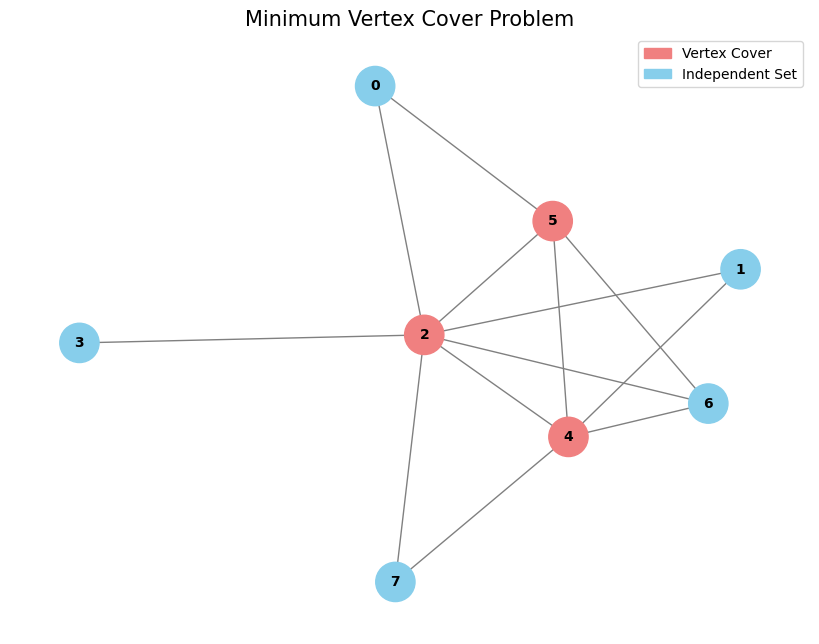

In [ ]:
visualize_vc_graph(generated_graph, solution)

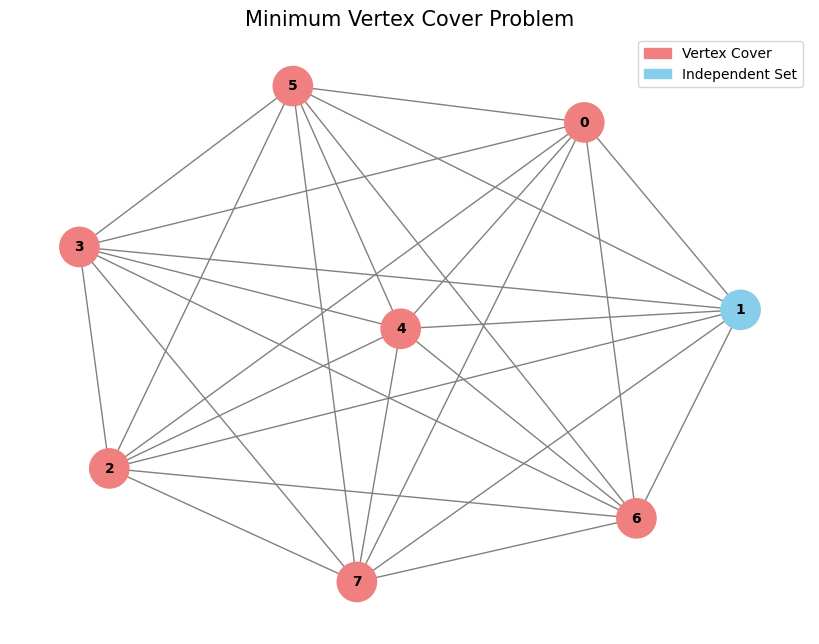

In [ ]:
generated_graph2, solution2 = generate_vc_problem(num_vertices=8, vc_ratio=0.999999, edge_density=1)
visualize_vc_graph(generated_graph2, solution2)

### Solving Problem Using Z3

In [ ]:
import time
from z3 import *

def solve_vertex_cover_with_z3(graph):
    start_time = time.time()
    solver = Optimize()
    vertex_vars = {v: Bool(f"v_{v}") for v in graph.keys()}

    for u in graph:
        for v in graph[u]:
            if u < v:
                solver.add(Or(vertex_vars[u], vertex_vars[v]))

    solver.minimize(Sum([If(vertex_vars[v], 1, 0) for v in graph.keys()]))

    check_result = solver.check()
    end_time = time.time()
    execution_time = end_time - start_time

    if check_result == sat:
        model = solver.model()
        vertex_cover = [v for v in graph.keys() if is_true(model[vertex_vars[v]])]
        return sorted(vertex_cover), execution_time
    else:
        return None, execution_time


generated_graph, solution = generate_vc_problem(num_vertices=8, vc_ratio=0.4, edge_density=0.5)
z3_solution, solve_time = solve_vertex_cover_with_z3(generated_graph)

print("=" * 75)
print(f"Total vertices: {len(generated_graph)}")
print("Generated Graph:")
for vertex, neighbors in sorted(generated_graph.items()):
    print(f"   {vertex}: {sorted(neighbors)}")

print("=" * 75)
print(f"Size of Planted Minimum Vertex Cover: {len(solution)}")
print(f"Planted Minimum Vertex Cover: {sorted(solution)}")
print("=" * 75)

if z3_solution is not None:
    print(f"Size of Z3 Found Minimum Vertex Cover: {len(z3_solution)}")
    print(f"Z3 Found Minimum Vertex Cover: {z3_solution}")
    print(f"Z3 Solver execution time: {solve_time:.6f} seconds")
else:
    print("Z3 could not find a solution.")
print("=" * 75)

Total vertices: 8
Generated Graph:
   0: [2, 5]
   1: [2, 4]
   2: [0, 1, 3, 4, 5, 6, 7]
   3: [2]
   4: [1, 2, 5, 6, 7]
   5: [0, 2, 4, 6]
   6: [2, 4, 5]
   7: [2, 4]
Size of Planted Minimum Vertex Cover: 3
Planted Minimum Vertex Cover: [2, 4, 5]
Size of Z3 Found Minimum Vertex Cover: 3
Z3 Found Minimum Vertex Cover: [2, 4, 5]
Z3 Solver execution time: 0.001356 seconds


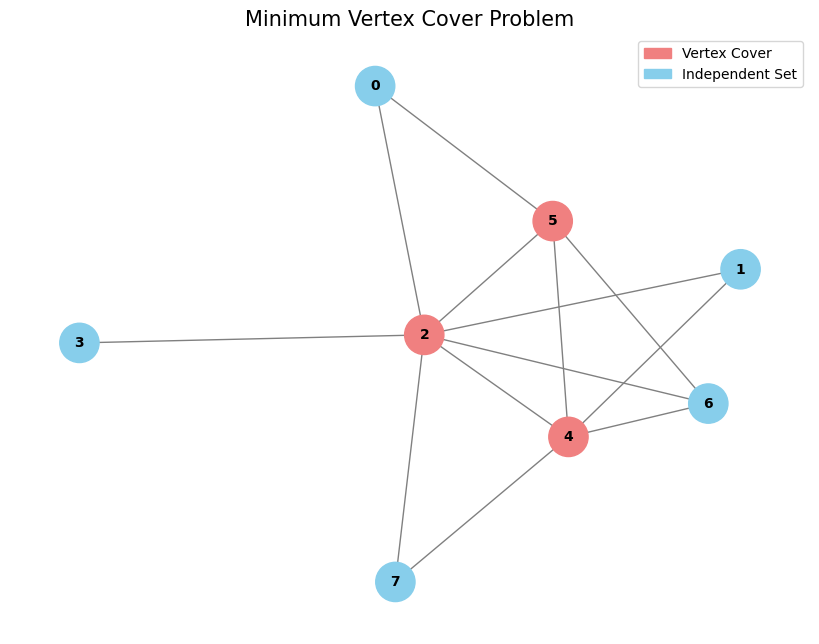

In [ ]:
visualize_vc_graph(generated_graph, z3_solution)

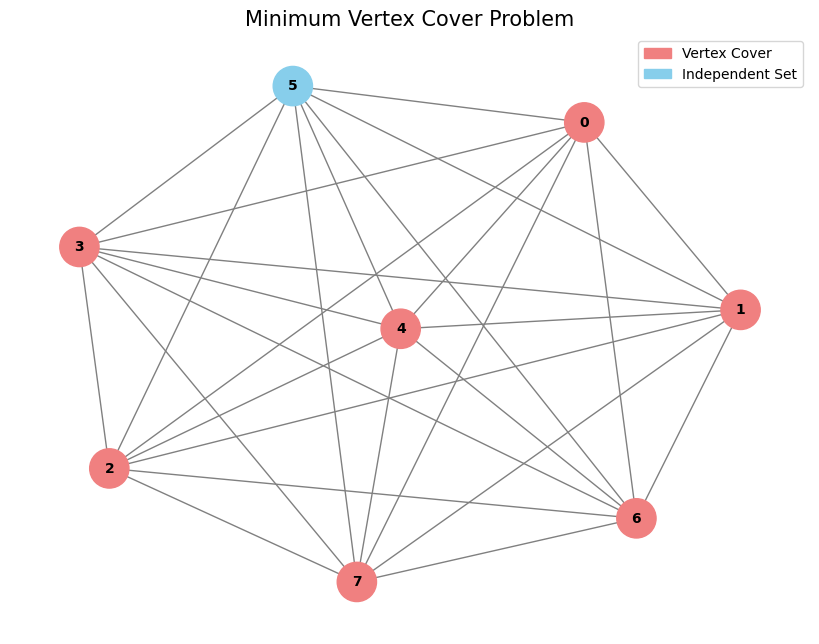

In [ ]:
generated_graph2, solution2 = generate_vc_problem(num_vertices=8, vc_ratio=0.999999, edge_density=1)
z3_solution2, _ = solve_vertex_cover_with_z3(generated_graph2)
visualize_vc_graph(generated_graph2, z3_solution2)

### Answer Verifier

In [ ]:
def verify_vc_solution(solution, graph, expected_size):
    if len(solution) != expected_size:
        return False, f"Verification FAILED: Incorrect size (Expected {expected_size} vertices but got {len(solution)})"

    solution_set = set(solution)
    uncovered_edges = []
    visited_edges = set()

    for u in graph:
        for v in graph[u]:
            edge = tuple(sorted((u, v)))
            if edge not in visited_edges:
                if u not in solution_set and v not in solution_set:
                    uncovered_edges.append(edge)
                visited_edges.add(edge)

    if len(uncovered_edges) == 0:
        return True, f"Verification PASSED: The solution is a valid vertex cover."
    else:
        return False, f"Verification FAILED: {len(uncovered_edges)} edges are not covered."

In [ ]:
generated_graph, solution = generate_vc_problem(num_vertices=50, vc_ratio=0.4, edge_density=0.6)
z3_solution, solve_time = solve_vertex_cover_with_z3(generated_graph)
min_vc_size = len(solution)

print("=" * 75)
print(f"Graph generated with {len(generated_graph)} vertices.")
print(f"Size of Planted Minimum Vertex Cover: {min_vc_size}")
print(f"Planted Minimum Vertex Cover: {sorted(solution)}")
print("=" * 75)


if z3_solution is not None:
    print(f"Size of Z3 Found Minimum Vertex Cover: {len(z3_solution)}")
    print(f"Z3 Found Minimum Vertex Cover: {z3_solution}")
    is_correct, message = verify_vc_solution(z3_solution, generated_graph, min_vc_size)
    print(message)
else:
    print("Z3 could not find a solution.")
print(f"Z3 Solver execution time: {solve_time:.6f} seconds")
print("=" * 75)

Graph generated with 50 vertices.
Size of Planted Minimum Vertex Cover: 20
Planted Minimum Vertex Cover: [0, 3, 5, 10, 15, 17, 20, 21, 30, 31, 32, 33, 36, 38, 40, 43, 45, 46, 47, 49]
Size of Z3 Found Minimum Vertex Cover: 20
Z3 Found Minimum Vertex Cover: [0, 3, 5, 10, 15, 17, 20, 21, 30, 31, 32, 33, 36, 38, 40, 43, 45, 46, 47, 49]
Verification PASSED: Solution is a valid vertex cover.
Z3 Solver execution time: 0.032385 seconds


## Maximum Clique Problem

### Problem Generator

In [ ]:
import random
import itertools

def add_edge(graph, u, v):
    if u not in graph[v]:
        graph[u].append(v)
        graph[v].append(u)

def generate_clique_problem(num_vertices, clique_size, edge_density = 0.5):
    graph = {i: [] for i in range(num_vertices)}
    all_vertices = list(range(num_vertices))
    random.shuffle(all_vertices)

    max_clique = all_vertices[:clique_size]
    other_vertices = all_vertices[clique_size:]

    clique_edges = list(itertools.combinations(max_clique, 2))
    for u, v in clique_edges:
        add_edge(graph, u, v)

    partitions = [[] for _ in range(clique_size)]
    for i, v in enumerate(other_vertices):
        partitions[i % clique_size].append(v)

    vertex_to_partition = {}
    for i, p in enumerate(partitions):
        for v in p:
            vertex_to_partition[v] = i

    for u, v in itertools.combinations(other_vertices, 2):
        if vertex_to_partition[u] != vertex_to_partition[v]:
            if random.random() < edge_density:
                add_edge(graph, u, v)

    for i, u in enumerate(max_clique):
        forbidden_partition_index = i % clique_size
        for v in other_vertices:
            if vertex_to_partition[v] != forbidden_partition_index:
                if random.random() < edge_density:
                    add_edge(graph, u, v)

    return graph, max_clique



generated_graph, solution = generate_clique_problem(num_vertices=20, clique_size=5, edge_density=0.5)

print("=" * 75)
print(f"Total vertices: {len(generated_graph)}")
print(f"Generated Graph:")
for vertex, neighbors in sorted(generated_graph.items()):
    print(f"   {vertex}: {sorted(neighbors)}")

print("=" * 75)
print(f"Size of Maximum clique: {len(solution)}")
print(f"Maximum Clique: {sorted(solution)}")
print("=" * 75)

Total vertices: 20
Generated Graph:
   0: [1, 4, 8, 9, 11, 15, 16, 18]
   1: [0, 2, 3, 6, 12, 13, 15, 17, 18, 19]
   2: [1, 4, 5, 8, 9, 10, 14, 15, 16, 17, 19]
   3: [1, 4, 8, 14, 16, 18, 19]
   4: [0, 2, 3, 5, 6, 7, 12, 16, 17]
   5: [2, 4, 6, 7, 10, 12, 16]
   6: [1, 4, 5, 7, 9, 11, 15, 17]
   7: [4, 5, 6, 11, 12, 14, 18, 19]
   8: [0, 2, 3, 11, 12, 18]
   9: [0, 2, 6, 11, 12, 16, 17, 18]
   10: [2, 5, 16, 17]
   11: [0, 6, 7, 8, 9, 12, 13, 14, 15, 16, 19]
   12: [1, 4, 5, 7, 8, 9, 11, 14, 15, 18, 19]
   13: [1, 11, 18]
   14: [2, 3, 7, 11, 12, 15, 16, 17, 19]
   15: [0, 1, 2, 6, 11, 12, 14, 17, 18]
   16: [0, 2, 3, 4, 5, 9, 10, 11, 14, 18]
   17: [1, 2, 4, 6, 9, 10, 14, 15, 19]
   18: [0, 1, 3, 7, 8, 9, 12, 13, 15, 16]
   19: [1, 2, 3, 7, 11, 12, 14, 17]
Size of Maximum clique: 5
Maximum Clique: [7, 11, 12, 14, 19]


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def visualize_clique_graph(graph, max_clique_nodes):
    G = nx.Graph(graph)
    node_colors = ['gold' if node in max_clique_nodes else 'lightgray' for node in G.nodes()]

    edge_colors = []
    edge_widths = []
    clique_edges = list(itertools.combinations(max_clique_nodes, 2))
    for u, v in G.edges():
        if (u, v) in clique_edges or (v, u) in clique_edges:
            edge_colors.append('red')
            edge_widths.append(2.5)
        else:
            edge_colors.append('gray')
            edge_widths.append(0.8)

    # pos = nx.spring_layout(G, seed=42, iterations=100)
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color=edge_colors, width=edge_widths, node_size=800, font_size=10)
    clique_patch = mpatches.Patch(color='gold', label='Maximum Clique Nodes')
    other_patch = mpatches.Patch(color='lightgray', label='Other Nodes')
    plt.legend(handles=[clique_patch, other_patch], loc='best')
    plt.title("Maximum Clique Problem", size=16)
    plt.show()

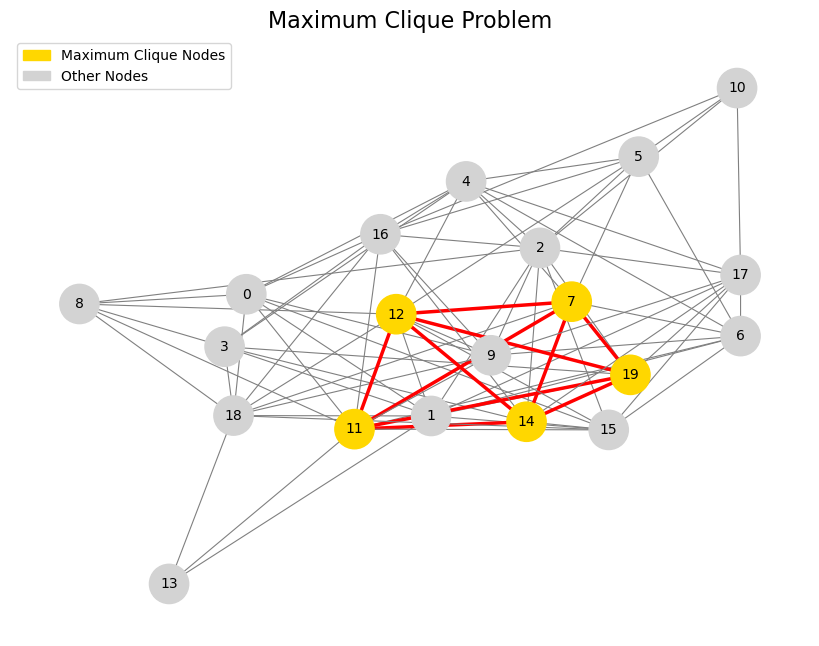

In [ ]:
visualize_clique_graph(generated_graph, solution)

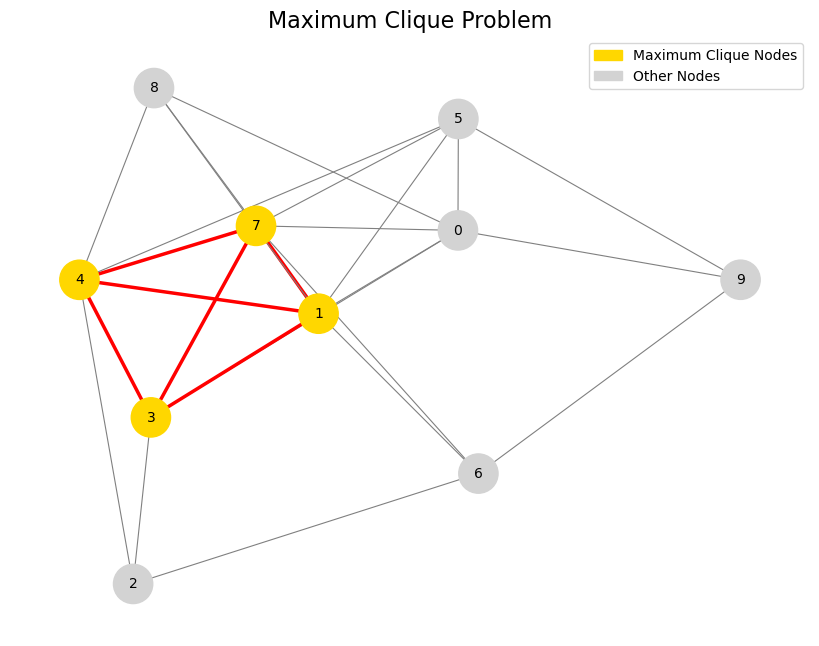

In [ ]:
generated_graph2, solution2 = generate_clique_problem(num_vertices=10, clique_size=4, edge_density=0.5)
visualize_clique_graph(generated_graph2, solution2)

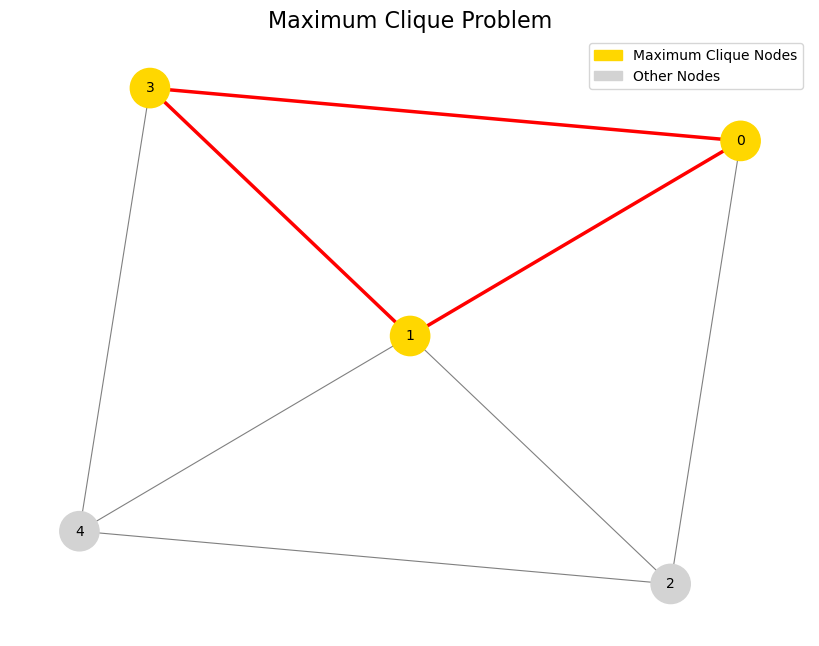

In [ ]:
generated_graph2, solution2 = generate_clique_problem(num_vertices=5, clique_size=3, edge_density=1)
visualize_clique_graph(generated_graph2, solution2)

### Solving Problem Using Z3

In [ ]:
from z3 import *

def solve_max_clique_with_z3(graph):
    start_time = time.time()
    solver = Optimize()

    vertex_vars = {v: Bool(f"v_{v}") for v in graph.keys()}

    non_adjacent_pairs = []
    all_vertices = list(graph.keys())
    for i in range(len(all_vertices)):
        for j in range(i + 1, len(all_vertices)):
            u, v = all_vertices[i], all_vertices[j]
            if v not in graph[u]:
                non_adjacent_pairs.append((u, v))

    for u, v in non_adjacent_pairs:
        solver.add(Or(Not(vertex_vars[u]), Not(vertex_vars[v])))

    clique_size = Sum([If(vertex_vars[v], 1, 0) for v in graph.keys()])
    solver.maximize(clique_size)

    check_result = solver.check()
    end_time = time.time()
    execution_time = end_time - start_time

    if check_result == sat:
        model = solver.model()
        max_clique = [v for v in graph.keys() if is_true(model.eval(vertex_vars[v]))]
        return sorted(max_clique), execution_time
    else:
        return None, execution_time


generated_graph, solution = generate_clique_problem(num_vertices=20, clique_size=5, edge_density=0.5)
z3_solution, solve_time = solve_max_clique_with_z3(generated_graph)

print("=" * 75)
print(f"Total vertices: {len(generated_graph)}")
print(f"Generated Graph:")
for vertex, neighbors in sorted(generated_graph.items()):
    print(f"   {vertex}: {sorted(neighbors)}")

print("=" * 75)
print(f"Size of Planted Maximum Clique: {len(solution)}")
print(f"Planted Maximum Clique: {sorted(solution)}")
print("=" * 75)

if z3_solution is not None:
    print(f"Size of Z3 Found Maximum Clique: {len(z3_solution)}")
    print(f"Z3 Found Maximum Clique: {z3_solution}")
else:
    print("Z3 could not find a solution.")
print(f"Z3 Solver execution time: {solve_time:.6f} seconds")
print("=" * 75)

Total vertices: 20
Generated Graph:
   0: [1, 4, 12, 14]
   1: [0, 5, 6, 7, 9, 10, 11, 13, 14, 15, 17, 18]
   2: [4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 19]
   3: [4, 8, 9, 14, 17, 18, 19]
   4: [0, 2, 3, 6, 7, 9, 10, 12, 13, 17, 19]
   5: [1, 2, 7, 10, 11, 15, 16, 17, 18]
   6: [1, 2, 4, 8, 10, 11, 12, 14, 16]
   7: [1, 2, 4, 5, 11, 12, 13, 19]
   8: [2, 3, 6, 11, 12, 13, 15]
   9: [1, 2, 3, 4, 11, 15, 17, 18]
   10: [1, 2, 4, 5, 6, 11, 12, 13, 16, 18, 19]
   11: [1, 5, 6, 7, 8, 9, 10, 16, 19]
   12: [0, 2, 4, 6, 7, 8, 10, 16, 17, 18]
   13: [1, 4, 7, 8, 10, 14, 16, 17, 19]
   14: [0, 1, 2, 3, 6, 13, 15, 19]
   15: [1, 5, 8, 9, 14, 18, 19]
   16: [2, 5, 6, 10, 11, 12, 13]
   17: [1, 3, 4, 5, 9, 12, 13]
   18: [1, 2, 3, 5, 9, 10, 12, 15]
   19: [2, 3, 4, 7, 10, 11, 13, 14, 15]
Size of Planted Maximum Clique: 5
Planted Maximum Clique: [2, 6, 10, 12, 16]
Size of Z3 Found Maximum Clique: 5
Z3 Found Maximum Clique: [2, 4, 6, 10, 12]
Z3 Solver execution time: 0.020440 seconds


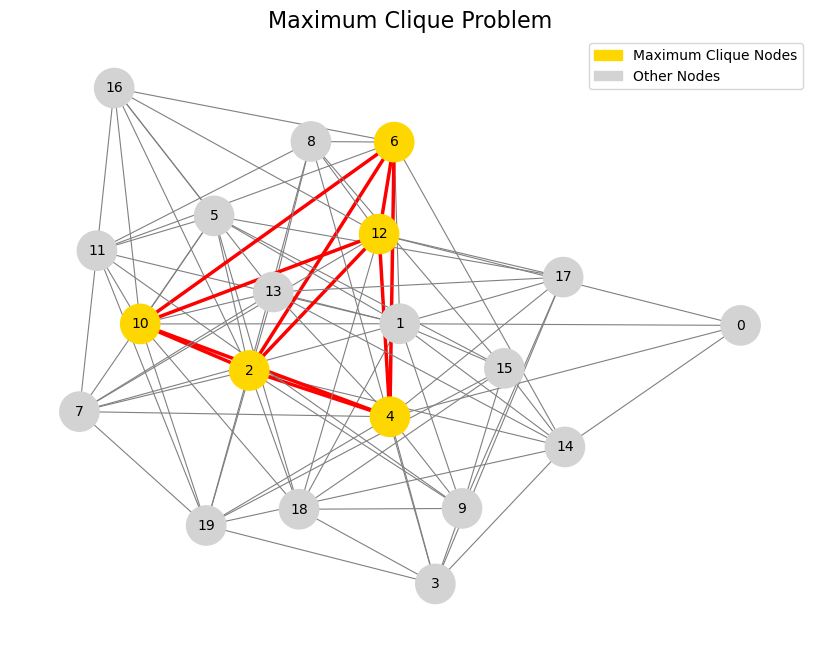

In [ ]:
visualize_clique_graph(generated_graph, z3_solution)

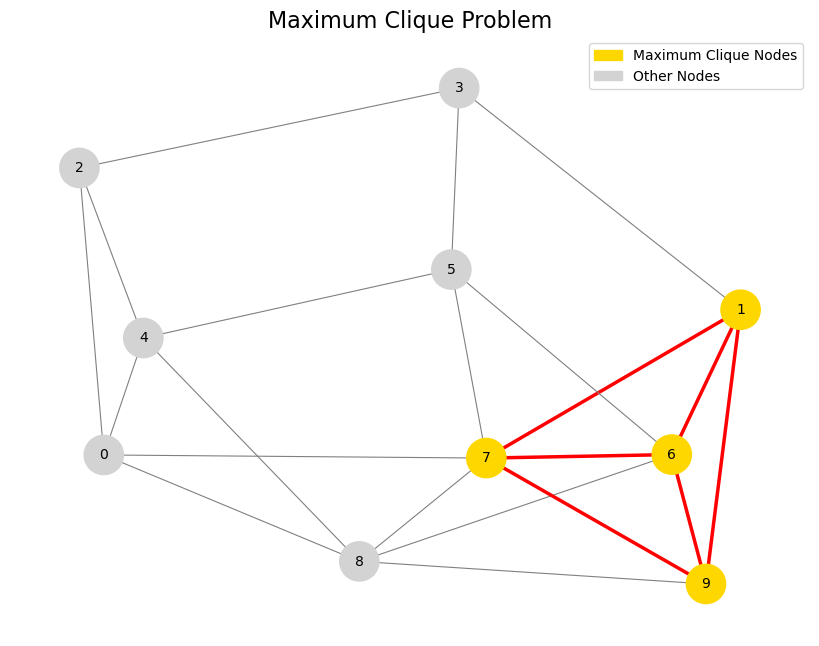

In [ ]:
generated_graph2, solution2 = generate_clique_problem(num_vertices=10, clique_size=4, edge_density=0.5)
z3_solution2, _ = solve_max_clique_with_z3(generated_graph2)
visualize_clique_graph(generated_graph2, z3_solution2)

### Answer Verifier

In [ ]:
import itertools

def verify_clique_solution(solution, graph, expected_size):
    if len(solution) != expected_size:
        return False, f"Verification FAILED: Incorrect size (Expected {expected_size} vertices but got {len(solution)})"
    if len(solution) > 1:
        missing_edges = []
        for u, v in itertools.combinations(solution, 2):
            if v not in graph[u] and u not in graph[v]:
                missing_edges.append((u, v))

        if len(missing_edges) != 0:
            return False, f"Verification FAILED: {len(missing_edges)} edges are missing."

    return True, f"Verification PASSED: The solution is a valid clique."

In [ ]:
CLIQUE_SIZE = 15
generated_graph, solution = generate_clique_problem(num_vertices=50, clique_size=CLIQUE_SIZE, edge_density=0.5)
z3_solution, solve_time = solve_max_clique_with_z3(generated_graph)

print("=" * 75)
print(f"Graph generated with {len(generated_graph)} vertices.")
print(f"Size of Planted Maximum Clique: {len(solution)}")
print(f"Planted Maximum Clique: {sorted(solution)}")
print("=" * 75)

if z3_solution is not None:
    print(f"Size of Z3 Found Maximum Clique: {len(z3_solution)}")
    print(f"Z3 Found Maximum Clique: {z3_solution}")
    is_correct, message = verify_clique_solution(z3_solution, generated_graph, CLIQUE_SIZE)
    print(message)
else:
    print("Z3 could not find a solution.")
print(f"Z3 Solver execution time: {solve_time:.6f} seconds")
print("=" * 75)

Graph generated with 50 vertices.
Size of Planted Maximum Clique: 15
Planted Maximum Clique: [1, 2, 6, 14, 19, 23, 24, 25, 27, 31, 33, 34, 35, 37, 38]
Size of Z3 Found Maximum Clique: 15
Z3 Found Maximum Clique: [1, 2, 6, 14, 19, 23, 24, 25, 27, 31, 33, 34, 35, 37, 38]
Verification PASSED: Solution is a valid clique.
Z3 Solver execution time: 0.058320 seconds


## Hamiltonian Path Problem

### Problem Generator

In [ ]:
import random

def add_edge(graph, u, v):
    if u not in graph[v]:
        graph[u].append(v)
        graph[v].append(u)

def generate_hamiltonian_path_graph(num_vertices, edge_density = 0.2):
    graph = {i: [] for i in range(num_vertices)}
    nodes = list(range(num_vertices))
    random.shuffle(nodes)
    hamiltonian_path = nodes

    path_edges = set()
    for i in range(num_vertices - 1):
        u = hamiltonian_path[i]
        v = hamiltonian_path[i + 1]
        add_edge(graph, u, v)
        path_edges.add((u, v))

    for u in range(num_vertices):
        for v in range(u + 1, num_vertices):
            if (u, v) not in path_edges and (v, u) not in path_edges:
                if random.random() < edge_density:
                    add_edge(graph, u, v)

    return graph, hamiltonian_path


generated_graph, solution_path = generate_hamiltonian_path_graph(num_vertices=10, edge_density=0.2)
solution_str = " -> ".join(map(str, solution_path))

print("=" * 75)
print(f"Total vertices: {len(generated_graph)}")
print(f"Generated Graph:")
for vertex, neighbors in sorted(generated_graph.items()):
    print(f"   {vertex}: {sorted(neighbors)}")

print("=" * 75)
print(f"Hamiltonian Path: {solution_str}")
print("=" * 75)

Total vertices: 10
Generated Graph:
   0: [1, 2, 7]
   1: [0, 3]
   2: [0, 7, 9]
   3: [1, 5, 7, 9]
   4: [6, 8]
   5: [3, 7, 8]
   6: [4, 8, 9]
   7: [0, 2, 3, 5, 9]
   8: [4, 5, 6, 9]
   9: [2, 3, 6, 7, 8]
Hamiltonian Path: 4 -> 6 -> 8 -> 9 -> 7 -> 5 -> 3 -> 1 -> 0 -> 2


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def visualize_hamiltonian_path_graph(adj_list_graph, path):
    G = nx.Graph(adj_list_graph)
    path_edges = [(path[i], path[i+1]) for i in range(len(path)-1)]

    pos = nx.spring_layout(G, seed=42, iterations=100)
    plt.figure(figsize=(8, 6))
    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=700)
    nx.draw_networkx_edges(G, pos, edge_color='lightgray', width=1.5)
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='limegreen', width=3.5)
    nx.draw_networkx_labels(G, pos, font_size=12, font_family="sans-serif")
    plt.title("Hamiltonian Path Problem", size=16)
    legend_path = mpatches.Patch(color='limegreen', label='Hamiltonian Path Edges')
    legend_other = mpatches.Patch(color='lightgray', label='Other Edges')
    plt.legend(handles=[legend_path, legend_other], loc='best')
    plt.axis('off')
    plt.show()

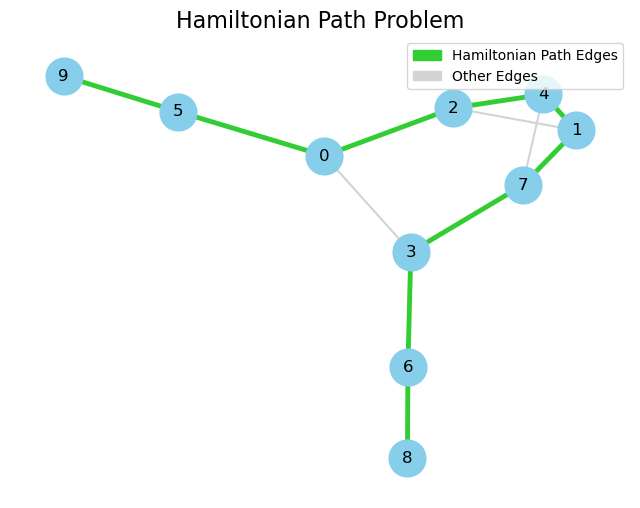

In [ ]:
visualize_hamiltonian_path_graph(generated_graph, solution_path)

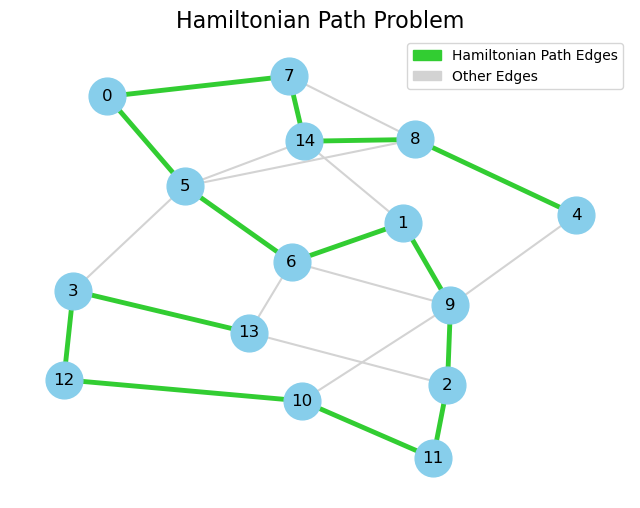

In [ ]:
generated_graph2, solution_path2 = generate_hamiltonian_path_graph(num_vertices=15, edge_density=0.1)
visualize_hamiltonian_path_graph(generated_graph2, solution_path2)

### Solving Problem Using Z3

In [ ]:
from z3 import *
import time

def solve_hamiltonian_path_with_z3(graph):
    start_time = time.time()
    num_vertices = len(graph)
    solver = Solver()
    pos_vars = {v: Int(f"pos_{v}") for v in graph.keys()}

    for v in graph.keys():
        solver.add(And(pos_vars[v] >= 0, pos_vars[v] < num_vertices))

    solver.add(Distinct(list(pos_vars.values())))

    all_vertices = list(graph.keys())
    for i in range(num_vertices):
        for j in range(i + 1, num_vertices):
            u, v = all_vertices[i], all_vertices[j]
            if v not in graph[u] and u not in graph[v]:
                solver.add(And(pos_vars[v] != pos_vars[u] + 1, pos_vars[u] != pos_vars[v] + 1))

    check_result = solver.check()
    end_time = time.time()
    execution_time = end_time - start_time

    if check_result == sat:
        model = solver.model()
        path_map = {model.eval(pos_vars[v]).as_long(): v for v in graph.keys()}
        hamiltonian_path = [path_map[i] for i in range(num_vertices)]
        return hamiltonian_path, execution_time
    else:
        return None, execution_time


NUM_VERTICES = 10
generated_graph, solution_path = generate_hamiltonian_path_graph(num_vertices=NUM_VERTICES, edge_density=0.2)
solution_str = " -> ".join(map(str, solution_path))
z3_solution, solve_time = solve_hamiltonian_path_with_z3(generated_graph)

print("=" * 75)
print(f"Total vertices: {len(generated_graph)}")
print("Generated Graph:")
for vertex, neighbors in sorted(generated_graph.items()):
    print(f"   {vertex}: {sorted(neighbors)}")

print("=" * 75)
print(f"Planted Hamiltonian Path: {solution_str}")
print("=" * 75)

if z3_solution is not None:
    z3_solution_str = " -> ".join(map(str, z3_solution))
    print(f"Z3 found Hamiltonian Path: {z3_solution_str}")
else:
    print("Z3 could not find a Hamiltonian Pach.")
print(f"Z3 Solver execution time: {solve_time:.6f} seconds")
print("=" * 75)

Total vertices: 10
Generated Graph:
   0: [1, 6, 7, 8]
   1: [0, 3, 4, 5, 7]
   2: [3, 5, 9]
   3: [1, 2, 4, 9]
   4: [1, 3, 7, 9]
   5: [1, 2, 9]
   6: [0, 8]
   7: [0, 1, 4, 8]
   8: [0, 6, 7]
   9: [2, 3, 4, 5]
Planted Hamiltonian Path: 6 -> 0 -> 8 -> 7 -> 4 -> 1 -> 5 -> 2 -> 3 -> 9
Z3 found Hamiltonian Path: 5 -> 9 -> 2 -> 3 -> 1 -> 4 -> 7 -> 0 -> 8 -> 6
Z3 Solver execution time: 0.159697 seconds


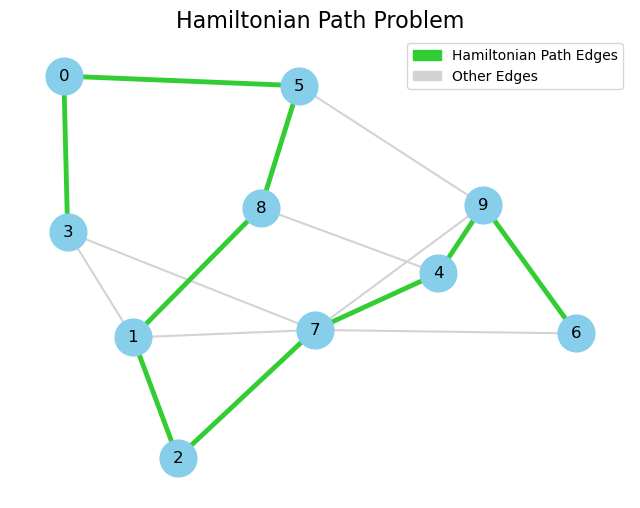

In [ ]:
visualize_hamiltonian_path_graph(generated_graph, z3_solution)

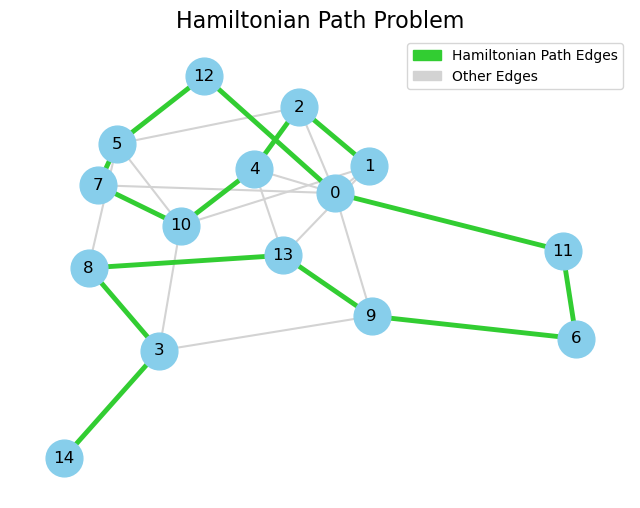

In [ ]:
generated_graph2, solution_path2 = generate_hamiltonian_path_graph(num_vertices=15, edge_density=0.2)
z3_solution2, _ = solve_hamiltonian_path_with_z3(generated_graph2)
visualize_hamiltonian_path_graph(generated_graph2, z3_solution2)

### Answer Verifier

In [ ]:
def verify_hamiltonian_path(path, graph):
    num_vertices = len(graph)
    if len(path) != num_vertices:
        return False, f"Verification FAILED: Incorrect size (Expected {num_vertices} vertices but got {len(path)})"

    if len(set(path)) != num_vertices:
        return False, "Verification FAILED: Path does not visit each vertex exactly once."

    for i in range(num_vertices - 1):
        u = path[i]
        v = path[i + 1]
        if v not in graph[u] and u not in graph[v]:
            return False, f"Verification FAILED: Path is not connected (Missing edge between {u} and {v})"

    return True, "Verification PASSED: The solution is a valid Hamiltonian Path."

In [ ]:
NUM_VERTICES = 20
generated_graph, solution_path = generate_hamiltonian_path_graph(num_vertices=NUM_VERTICES, edge_density=0.2)
solution_str = " -> ".join(map(str, solution_path))
z3_solution, solve_time = solve_hamiltonian_path_with_z3(generated_graph)

print("=" * 75)
print(f"Graph generated with {NUM_VERTICES} vertices.")
print(f"Planted Hamiltonian Path: {solution_str}")
print("=" * 75)

if z3_solution is not None:
    z3_solution_str = " -> ".join(map(str, z3_solution))
    print(f"Z3 found Hamiltonian Path: {z3_solution_str}")
    is_correct, message = verify_hamiltonian_path(z3_solution, generated_graph)
    print(message)
else:
    print("Z3 could not find a Hamiltonian Path.")
print(f"Z3 Solver execution time: {solve_time:.6f} seconds")
print("=" * 75)

Graph generated with 20 vertices.
Planted Hamiltonian Path: 13 -> 2 -> 17 -> 11 -> 1 -> 5 -> 3 -> 12 -> 18 -> 8 -> 14 -> 4 -> 0 -> 16 -> 19 -> 9 -> 6 -> 15 -> 7 -> 10
Z3 found Hamiltonian Path: 2 -> 10 -> 18 -> 15 -> 19 -> 16 -> 0 -> 4 -> 17 -> 14 -> 7 -> 8 -> 12 -> 3 -> 6 -> 9 -> 11 -> 1 -> 13 -> 5
Verification PASSED: The solution is a valid Hamiltonian Path.
Z3 Solver execution time: 25.100065 seconds


## Hamiltonian Cycle Problem

### Problem Generator

In [ ]:
import random

def add_edge(graph, u, v):
    if u not in graph[v]:
        graph[u].append(v)
        graph[v].append(u)

def generate_hamiltonian_cycle_graph(num_vertices, edge_density = 0.2):
    graph = {i: [] for i in range(num_vertices)}
    nodes = list(range(num_vertices))
    random.shuffle(nodes)
    hamiltonian_cycle_path = nodes

    cycle_edges = set()
    for i in range(num_vertices):
        u = hamiltonian_cycle_path[i]
        v = hamiltonian_cycle_path[(i + 1) % num_vertices]
        add_edge(graph, u, v)
        cycle_edges.add((u, v))

    for u in range(num_vertices):
        for v in range(u + 1, num_vertices):
            if (u, v) not in cycle_edges and (v, u) not in cycle_edges:
                if random.random() < edge_density:
                    add_edge(graph, u, v)

    return graph, hamiltonian_cycle_path



generated_graph, solution_path = generate_hamiltonian_cycle_graph(num_vertices=10, edge_density=0.2)
solution_str = " -> ".join(map(str, solution_path)) + " -> " + str(solution_path[0])

print("=" * 75)
print(f"Total vertices: {len(generated_graph)}")
print(f"Generated Graph:")
for vertex, neighbors in sorted(generated_graph.items()):
    print(f"   {vertex}: {sorted(neighbors)}")

print("=" * 75)
print(f"Hamiltonian Cycle: {solution_str}")
print("=" * 75)

Total vertices: 10
Generated Graph:
   0: [1, 8]
   1: [0, 3]
   2: [3, 4, 7, 9]
   3: [1, 2, 6]
   4: [2, 6, 7, 8]
   5: [6, 7]
   6: [3, 4, 5, 8]
   7: [2, 4, 5, 9]
   8: [0, 4, 6]
   9: [2, 7]
Hamiltonian Cycle: 4 -> 6 -> 5 -> 7 -> 9 -> 2 -> 3 -> 1 -> 0 -> 8 -> 4


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def visualize_hamiltonian_cycle_graph(graph, cycle_path):

    G = nx.Graph(graph)
    hc_edges = []
    for i in range(len(cycle_path)):
        u = cycle_path[i]
        v = cycle_path[(i + 1) % len(cycle_path)]
        hc_edges.append((u, v))

    pos = nx.circular_layout(cycle_path)
    plt.figure(figsize=(8, 8))
    nx.draw_networkx_nodes(G, pos, node_color="skyblue", node_size=700)
    nx.draw_networkx_edges(G, pos, edge_color="lightgray", width=1.5)
    nx.draw_networkx_edges(G, pos, edgelist=hc_edges, edge_color="crimson", width=3.0)
    nx.draw_networkx_labels(G, pos, font_size=12, font_family="sans-serif")
    plt.title("Hamiltonian Cycle Problem", size=16)
    legend_cycle = mpatches.Patch(color="crimson", label="Hamiltonian Cycle Edges")
    legend_other = mpatches.Patch(color="lightgray", label="Other Edges")
    plt.legend(handles=[legend_cycle, legend_other], loc="best")
    plt.axis("off")
    plt.show()

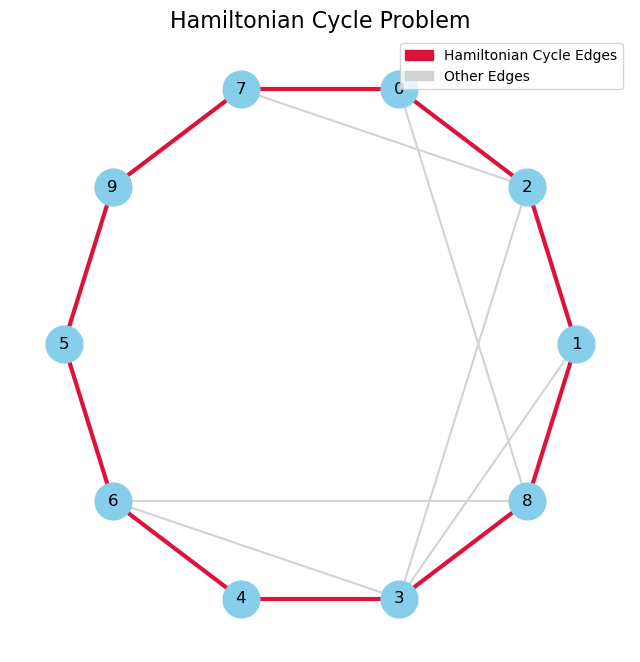

In [ ]:
visualize_hamiltonian_cycle_graph(generated_graph, solution_path)

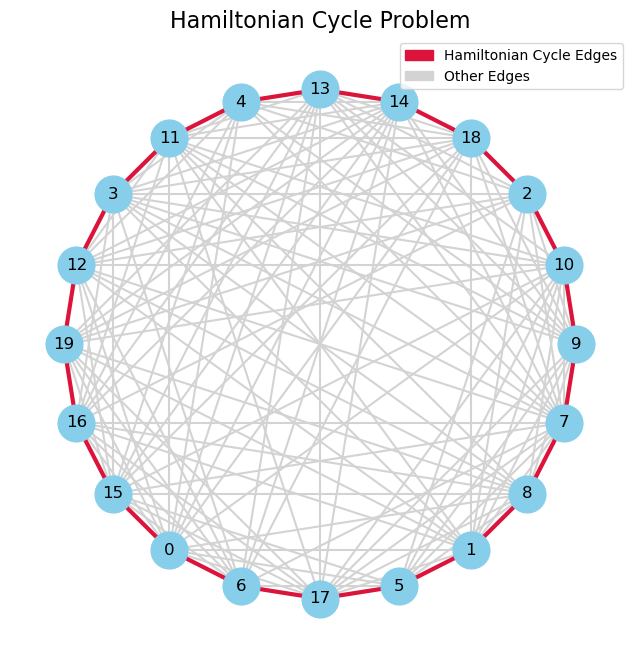

In [ ]:
generated_graph2, solution_path2 = generate_hamiltonian_cycle_graph(num_vertices=20, edge_density=0.7)
visualize_hamiltonian_cycle_graph(generated_graph2, solution_path2)

### Solving Problem Using Z3

In [ ]:
from z3 import *
import time

def solve_hamiltonian_cycle_with_z3(graph):
    start_time = time.time()
    num_vertices = len(graph)
    solver = Solver()

    pos_vars = {v: Int(f"pos_{v}") for v in graph.keys()}

    for v in graph.keys():
        solver.add(And(pos_vars[v] >= 0, pos_vars[v] < num_vertices))

    solver.add(Distinct(list(pos_vars.values())))

    all_vertices = list(graph.keys())
    for i in range(num_vertices):
        for j in range(i + 1, num_vertices):
            u, v = all_vertices[i], all_vertices[j]
            if v not in graph[u] and u not in graph[v]:
                solver.add(And((pos_vars[u] + 1) % num_vertices != pos_vars[v], (pos_vars[v] + 1) % num_vertices != pos_vars[u]))

    check_result = solver.check()
    end_time = time.time()
    execution_time = end_time - start_time

    if check_result == sat:
        model = solver.model()
        path_map = {}
        for v in graph.keys():
            position = model.eval(pos_vars[v]).as_long()
            path_map[position] = v

        hamiltonian_cycle = [path_map[i] for i in range(num_vertices)]
        return hamiltonian_cycle, execution_time
    else:
        return None, execution_time


NUM_VERTICES = 8
generated_graph, solution_path = generate_hamiltonian_cycle_graph(num_vertices=NUM_VERTICES, edge_density=0.2)
solution_str = " -> ".join(map(str, solution_path)) + " -> " + str(solution_path[0])
z3_solution, solve_time = solve_hamiltonian_cycle_with_z3(generated_graph)

print("=" * 75)
print(f"Total vertices: {len(generated_graph)}")
print("Generated Graph:")
for vertex, neighbors in sorted(generated_graph.items()):
    print(f"   {vertex}: {sorted(neighbors)}")

print("=" * 75)
print(f"Planted Hamiltonian Cycle: {solution_str}")
print("=" * 75)

if z3_solution is not None:
    z3_solution_str = " -> ".join(map(str, z3_solution)) + " -> " + str(z3_solution[0])
    print(f"Z3 found Hamiltonian Cycle: {z3_solution_str}")
else:
    print("Z3 could not find a Hamiltonian Cycle.")
print(f"Z3 Solver execution time: {solve_time:.6f} seconds")
print("=" * 75)

Total vertices: 8
Generated Graph:
   0: [1, 2, 4]
   1: [0, 2, 4, 5, 7]
   2: [0, 1, 5]
   3: [6, 7]
   4: [0, 1, 5, 6]
   5: [1, 2, 4]
   6: [3, 4]
   7: [1, 3]
Planted Hamiltonian Cycle: 7 -> 3 -> 6 -> 4 -> 5 -> 2 -> 0 -> 1 -> 7
Z3 found Hamiltonian Cycle: 3 -> 7 -> 1 -> 5 -> 2 -> 0 -> 4 -> 6 -> 3
Z3 Solver execution time: 0.364708 seconds


In [ ]:
from z3 import Real, prove, Implies, And

# Define the coordinates of the triangle's vertices
x, y = Real('x'), Real('y')

# Use And to combine constraints properly
A = And(x>=1, y>=1)

theorem = Implies(A, 1/x+1/y<2)

prove(theorem)

counterexample
[y = 1, x = 1, /0 = [(1, 1) -> 1, else -> 0]]


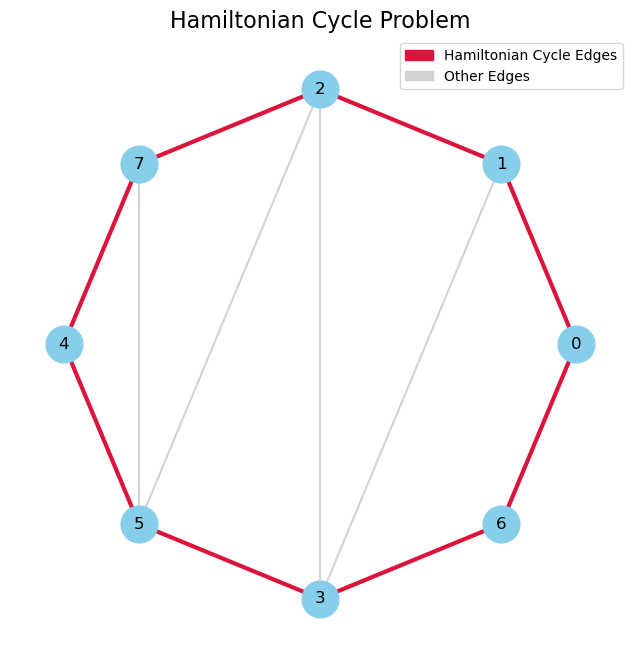

In [ ]:
visualize_hamiltonian_cycle_graph(generated_graph, z3_solution)

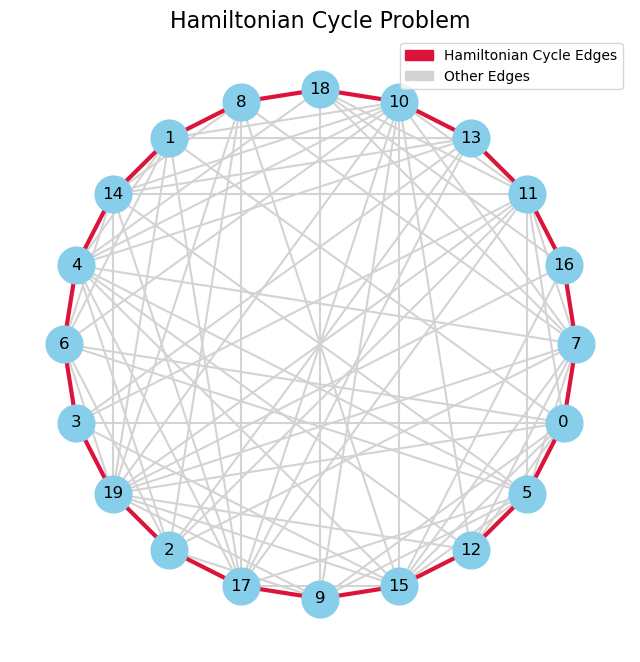

In [ ]:
generated_graph2, solution_path2 = generate_hamiltonian_cycle_graph(num_vertices=20, edge_density=0.5)
z3_solution2, _ = solve_hamiltonian_cycle_with_z3(generated_graph2)
visualize_hamiltonian_cycle_graph(generated_graph2, z3_solution2)

### Answer Verifier

In [ ]:
def verify_hamiltonian_cycle(path, graph):
    num_vertices = len(graph)
    if len(path) != num_vertices:
        return False, f"Verification FAILED: Incorrect size (Expected {num_vertices} vertices but got {len(path)})"

    if len(set(path)) != num_vertices:
        return False, f"Verification FAILED: Path does not visit each vertex exactly once."

    for i in range(num_vertices - 1):
        u = path[i]
        v = path[i + 1]
        if v not in graph[u] and u not in graph[v]:
            return False, f"Verification FAILED: Path is not connected (Missing edge between {u} and {v})"

    last_vertex = path[-1]
    first_vertex = path[0]
    if first_vertex not in graph[last_vertex] and last_vertex not in graph[first_vertex]:
        return False, f"Verification FAILED: Path is not a cycle (Missing closing edge between {last_vertex} and {first_vertex})"

    return True, "Verification PASSED: The solution is a valid Hamiltonian Cycle."

In [ ]:
NUM_VERTICES = 12
generated_graph, solution_path = generate_hamiltonian_cycle_graph(num_vertices=NUM_VERTICES, edge_density=0.2)
solution_str = " -> ".join(map(str, solution_path)) + " -> " + str(solution_path[0])
z3_solution, solve_time = solve_hamiltonian_cycle_with_z3(generated_graph)

print("=" * 75)
print(f"Graph generated with {NUM_VERTICES} vertices.")
print(f"Planted Hamiltonian Cycle: {solution_str}")
print("=" * 75)


if z3_solution is not None:
    z3_solution_str = " -> ".join(map(str, z3_solution)) + " -> " + str(z3_solution[0])
    print(f"Z3 found Hamiltonian Cycle: {z3_solution_str}")
    is_correct, message = verify_hamiltonian_cycle(z3_solution, generated_graph)
    print(message)
else:
    print("Z3 could not find a Hamiltonian Cycle.")
print(f"Z3 Solver execution time: {solve_time:.6f} seconds")
print("=" * 75)

Graph generated with 12 vertices.
Planted Hamiltonian Cycle: 4 -> 9 -> 11 -> 2 -> 3 -> 7 -> 0 -> 6 -> 8 -> 1 -> 10 -> 5 -> 4
Z3 found Hamiltonian Cycle: 10 -> 8 -> 6 -> 1 -> 11 -> 9 -> 5 -> 4 -> 0 -> 7 -> 3 -> 2 -> 10
Verification PASSED: The solution is a valid Hamiltonian Cycle.
Z3 Solver execution time: 10.904397 seconds
